In [356]:
!pip install nltk
!pip install shap
!pip install googletrans==4.0.0-rc1

In [357]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import string
import ast
import nltk

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from googletrans import Translator


In [358]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Preparation
In this step, we will remove unnecessary features and merge related sub-datasets with the goal of creating a new large dataset for the next step of feature engineering and modeling.

In [359]:
# Load all dataset related to the model and clean the data
df_messages = pd.read_csv('/content/drive/MyDrive/dataset/messages_data.csv') #(2560,6)
df_users = pd.read_csv('/content/drive/MyDrive/dataset/user_information.csv') # (83,11)
df_events = pd.read_csv('/content/drive/MyDrive/dataset/emotional_events.csv') #(1641,14) There are no values for arousal and valence for rows with input_type prompt, but llm_answer

## Check user_information dataset

In [360]:
# Check and Rename id in df_users to userId
df_users = df_users.rename(columns={'id': 'userId'})
df_users.head()

,userId,age,gender,education,assistant_usage,experience_analysis_tools,Trust 1,Trust 2,Trust 3,Satisfaction,Anthropomorphism
0,124,30,male,bachelor,weekly,5,1,1,2,2,1
1,125,49,female,bachelor,daily,7,7,7,4,4,1
2,126,23,female,abitur,monthly,2,4,3,3,3,1
3,128,29,female,abitur,monthly,3,7,4,6,5,2
4,129,28,male,bachelor,weekly,5,6,6,5,6,1


## Check emotional_events dataset
Here, we create a new variable called "**prompt_VADER**" using the VADER model. **VADER** (Valence Aware Dictionary and sEtiment Reasoner) is a sentiment analysis tool that uses a lexicon and rule-based approach to assess the sentiment of short, informal texts, taking into account intensity, negation, and slang. It outputs a composite score from **-1 (most negative) to 1 (most positive) to represent the overall sentiment. **prompt_VADER represents how the user feels when they first prompt a large language model to perform an information finding task.

Additionaly, we create a new variable called **length_of_prompt**, which is the length of first prompt.

We wanted to test whether the **initial sentiment value** and the **length of the prompt** affect the **valence** after interacting with the llm.

In [361]:
# Check the original emotional events dataset
df_events.head()

,id,userId,task_type,task,input_type,input,input_assessment,confidence,understanding,valence,arousal,task_start,task_end,task_time
0,NaN,124,information_finding,1,final_output,"Unterwiehre-Süd, Herdern-Nord, Oberwiehre, Wal...",NaN,6.0,7.0,5,6,1.719301e+12,1.719301e+12,56.03
1,NaN,124,information_finding,1,prompt,Nennen Sie alle Bezirke in einer durch Kommata...,NaN,NaN,NaN,NaN,NaN,NaN,1.719301e+09,NaN
2,NaN,124,information_finding,2,final_output,Dauert zu lange,NaN,1.0,1.0,1,5,1.719301e+12,1.719302e+12,103.50
3,NaN,124,information_finding,2,prompt,Nennen Sie die Einwohnerzahlen die sich aus de...,NaN,NaN,NaN,NaN,NaN,NaN,1.719301e+09,NaN
4,NaN,124,information_finding,3,final_output,Alt-Stühlinger,NaN,2.0,3.0,3,5,1.719301e+12,1.719301e+12,124.84


In [362]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                0 non-null      float64
 1   userId            1641 non-null   int64  
 2   task_type         1641 non-null   object 
 3   task              1641 non-null   int64  
 4   input_type        1641 non-null   object 
 5   input             1636 non-null   object 
 6   input_assessment  0 non-null      float64
 7   confidence        405 non-null    float64
 8   understanding     405 non-null    float64
 9   valence           1244 non-null   object 
 10  arousal           1244 non-null   object 
 11  task_start        405 non-null    float64
 12  task_end          1155 non-null   float64
 13  task_time         891 non-null    float64
dtypes: float64(7), int64(2), object(5)
memory usage: 179.6+ KB


Since our target variable is valence, it makes sense to drop all dependent variables that do not contain the **valence** variable.  Furthermore, we only study the problem of information finding.

In [363]:
df_events_new = df_events.copy()
# Only study the problem of information finding
df_events_new = df_events_new[df_events_new['task_type'] == 'information_finding']
df_events_new = df_events_new[df_events_new['input_type'] != 'llm_answer']
# Remove all unnecessary features
df_events_new.drop(columns=['id','input_assessment','arousal','task_start','task_end'], inplace=True)
#Reseting the index
df_events_new.reset_index(drop=True, inplace=True)
df_events_new

,userId,task_type,task,input_type,input,confidence,understanding,valence,task_time
0,124,information_finding,1,final_output,"Unterwiehre-Süd, Herdern-Nord, Oberwiehre, Wal...",6.0,7.0,5,56.03
1,124,information_finding,1,prompt,Nennen Sie alle Bezirke in einer durch Kommata...,NaN,NaN,NaN,NaN
2,124,information_finding,2,final_output,Dauert zu lange,1.0,1.0,1,103.50
3,124,information_finding,2,prompt,Nennen Sie die Einwohnerzahlen die sich aus de...,NaN,NaN,NaN,NaN
4,124,information_finding,3,final_output,Alt-Stühlinger,2.0,3.0,3,124.84
...,...,...,...,...,...,...,...,...,...
797,238,information_finding,3,prompt,in welchem Stadtbezirk gab es 2020 die meisten...,NaN,NaN,NaN,NaN
798,238,information_finding,4,final_output,10698,2.0,2.0,2,175.46
799,238,information_finding,4,prompt,Wie ist die Kitaquote der Gesamtstadt Freiburg...,NaN,NaN,NaN,NaN
800,238,information_finding,5,final_output,Oberwiehre,1.0,1.0,1,252.03


In [364]:
# Create a new feature using VADER model

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer and the translator
sid = SentimentIntensityAnalyzer()
translator = Translator()

# Define a function to translate German text to English and get the compound sentiment score
def translate_and_get_valence_score(text, src_lang='de'):
    # Translate the German text to English
    translated_text = translator.translate(text, src=src_lang, dest='en').text
    # Use VADER to analyze the translated text
    return sid.polarity_scores(translated_text)['compound']


# Create a dictionary to store the prompt_VADER scores
prompt_vader_dict = {}

# Loop through the DataFrame and calculate the prompt_VADER for rows with input_type 'prompt'
for index, row in df_events_new.iterrows():
    if row['input_type'] == 'prompt':
        # Calculate the prompt_VADER score
        prompt_vader_score = translate_and_get_valence_score(row['input'])
        # Store the score in the dictionary with userId, task_type, and task as the key
        key = (row['userId'], row['task_type'], row['task'])
        prompt_vader_dict[key] = prompt_vader_score

# Create a new column 'prompt_VADER' and set it to None initially
df_events_new['prompt_VADER'] = None

# Assign the prompt_VADER scores to the corresponding rows with input_type 'final_output'
for index, row in df_events_new.iterrows():
    if row['input_type'] == 'final_output':
        key = (row['userId'], row['task_type'], row['task'])
        if key in prompt_vader_dict:
            df_events_new.at[index, 'prompt_VADER'] = prompt_vader_dict[key]
df_events_new

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,userId,task_type,task,input_type,input,confidence,understanding,valence,task_time,prompt_VADER
0,124,information_finding,1,final_output,"Unterwiehre-Süd, Herdern-Nord, Oberwiehre, Wal...",6.0,7.0,5,56.03,-0.296
1,124,information_finding,1,prompt,Nennen Sie alle Bezirke in einer durch Kommata...,NaN,NaN,NaN,NaN,None
2,124,information_finding,2,final_output,Dauert zu lange,1.0,1.0,1,103.50,0.0
3,124,information_finding,2,prompt,Nennen Sie die Einwohnerzahlen die sich aus de...,NaN,NaN,NaN,NaN,None
4,124,information_finding,3,final_output,Alt-Stühlinger,2.0,3.0,3,124.84,0.0772
...,...,...,...,...,...,...,...,...,...,...
797,238,information_finding,3,prompt,in welchem Stadtbezirk gab es 2020 die meisten...,NaN,NaN,NaN,NaN,None
798,238,information_finding,4,final_output,10698,2.0,2.0,2,175.46,0.0772
799,238,information_finding,4,prompt,Wie ist die Kitaquote der Gesamtstadt Freiburg...,NaN,NaN,NaN,NaN,None
800,238,information_finding,5,final_output,Oberwiehre,1.0,1.0,1,252.03,0.0


In [365]:
import string

# Define the function to count words
def count_words(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Split the text by spaces and count the number of words
    return len(text.split())

# Create a dictionary to store the prompt word counts
prompt_word_count_dict = {}

# Loop through the DataFrame and calculate the word count for rows with input_type 'prompt'
for index, row in df_events_new.iterrows():
    if row['input_type'] == 'prompt':
        # Calculate the word count of the prompt text
        prompt_word_count = count_words(row['input'])
        # Store the word count in the dictionary with userId, task_type, and task as the key
        key = (row['userId'], row['task_type'], row['task'])
        prompt_word_count_dict[key] = prompt_word_count

# Create a new column 'prompt_length' and set it to None initially
df_events_new['prompt_length'] = None

# Assign the prompt word counts to the corresponding rows with input_type 'final_output'
for index, row in df_events_new.iterrows():
    if row['input_type'] == 'final_output':
        key = (row['userId'], row['task_type'], row['task'])
        if key in prompt_word_count_dict:
            df_events_new.at[index, 'prompt_length'] = prompt_word_count_dict[key]

# Display the updated DataFrame
df_events_new

,userId,task_type,task,input_type,input,confidence,understanding,valence,task_time,prompt_VADER,prompt_length
0,124,information_finding,1,final_output,"Unterwiehre-Süd, Herdern-Nord, Oberwiehre, Wal...",6.0,7.0,5,56.03,-0.296,27
1,124,information_finding,1,prompt,Nennen Sie alle Bezirke in einer durch Kommata...,NaN,NaN,NaN,NaN,None,None
2,124,information_finding,2,final_output,Dauert zu lange,1.0,1.0,1,103.50,0.0,16
3,124,information_finding,2,prompt,Nennen Sie die Einwohnerzahlen die sich aus de...,NaN,NaN,NaN,NaN,None,None
4,124,information_finding,3,final_output,Alt-Stühlinger,2.0,3.0,3,124.84,0.0772,16
...,...,...,...,...,...,...,...,...,...,...,...
797,238,information_finding,3,prompt,in welchem Stadtbezirk gab es 2020 die meisten...,NaN,NaN,NaN,NaN,None,None
798,238,information_finding,4,final_output,10698,2.0,2.0,2,175.46,0.0772,21
799,238,information_finding,4,prompt,Wie ist die Kitaquote der Gesamtstadt Freiburg...,NaN,NaN,NaN,NaN,None,None
800,238,information_finding,5,final_output,Oberwiehre,1.0,1.0,1,252.03,0.0,12


In [366]:
#Remove all valence equals to NaN
df_events_new = df_events_new.dropna(subset=['valence'])
df_events_new.drop(columns=['task_type','input_type'], inplace=True)
# Rename the input to final_output, now we only consider the final output from llm
df_events_new = df_events_new.rename(columns={'input': 'final_output'})

df_events_new

<ipython-input-366-d345c4122356>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_new.drop(columns=['task_type','input_type'], inplace=True)


,userId,task,final_output,confidence,understanding,valence,task_time,prompt_VADER,prompt_length
0,124,1,"Unterwiehre-Süd, Herdern-Nord, Oberwiehre, Wal...",6.0,7.0,5,56.03,-0.296,27
2,124,2,Dauert zu lange,1.0,1.0,1,103.50,0.0,16
4,124,3,Alt-Stühlinger,2.0,3.0,3,124.84,0.0772,16
6,124,4,93.238,1.0,1.0,1,103.90,0.0772,12
8,124,5,Dauert zu lange,1.0,1.0,1,85.63,0.5106,22
...,...,...,...,...,...,...,...,...,...
792,238,1,"Alt-Betzenhausen, Alt-Stühlinger, Altstadt, Al...",1.0,1.0,1,345.70,0.3182,20
794,238,2,227.537,1.0,1.0,1,211.52,0.3182,8
796,238,3,Alt-Stühlinger,3.0,1.0,2,217.16,0.0,9
798,238,4,10698,2.0,2.0,2,175.46,0.0772,21


In [367]:
# Check all unique userId
df_events_new['userId'].unique() #len(df_events_new['userId'].unique()) = 82

array([124, 125, 126, 128, 129, 131, 133, 134, 135, 136, 138, 140, 141,
       142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 159, 160, 161, 163, 167, 168, 169, 170, 171, 173, 174, 175,
       176, 177, 178, 179, 180, 182, 183, 185, 186, 187, 189, 190, 191,
       192, 193, 198, 199, 201, 203, 206, 208, 209, 211, 215, 216, 217,
       219, 221, 222, 223, 224, 225, 226, 228, 229, 230, 232, 233, 234,
       235, 237, 238])

Note: Although we collected basic user information for user ID 181, since this user did not give a sentiment score.
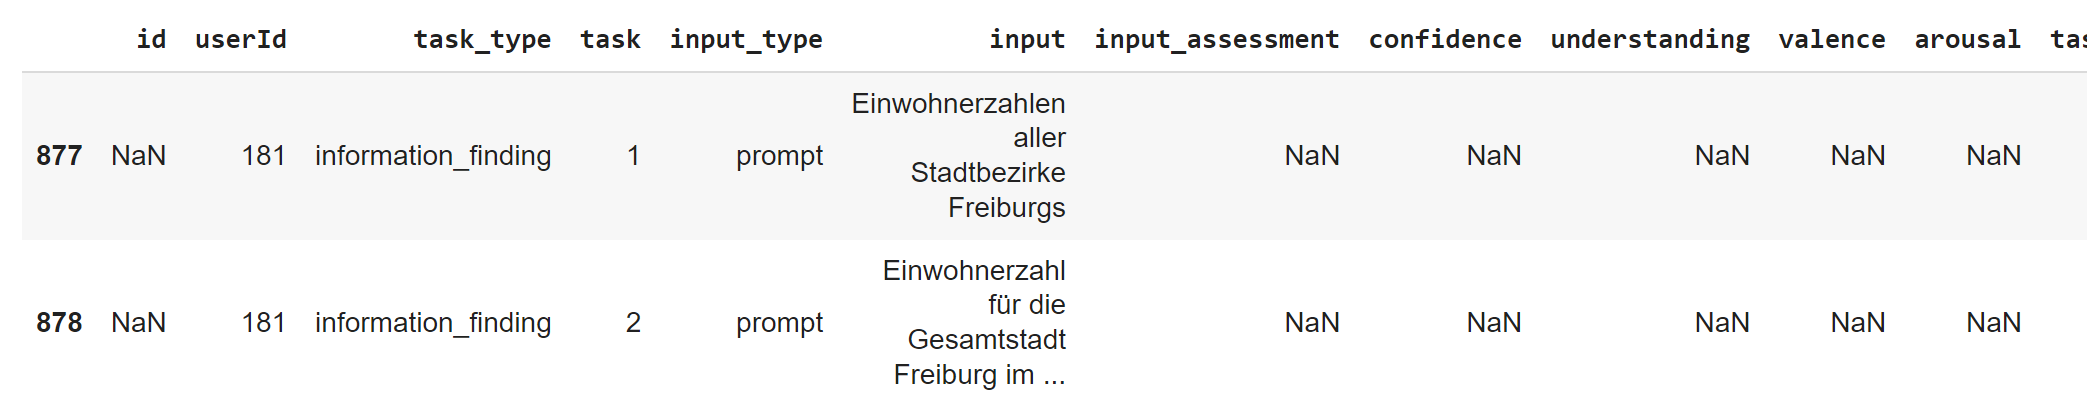

In [368]:
df_events_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 0 to 800
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userId         405 non-null    int64  
 1   task           405 non-null    int64  
 2   final_output   405 non-null    object 
 3   confidence     405 non-null    float64
 4   understanding  405 non-null    float64
 5   valence        405 non-null    object 
 6   task_time      405 non-null    float64
 7   prompt_VADER   390 non-null    object 
 8   prompt_length  390 non-null    object 
dtypes: float64(3), int64(2), object(4)
memory usage: 47.8+ KB


As shown in the figure below, since some users initially forget to prompt the large language model, this means the input is empty. For similarity, we assume that in this case, prompt_VADER is equal to 0, which means that the user has neural valence in this case, which makes sense.
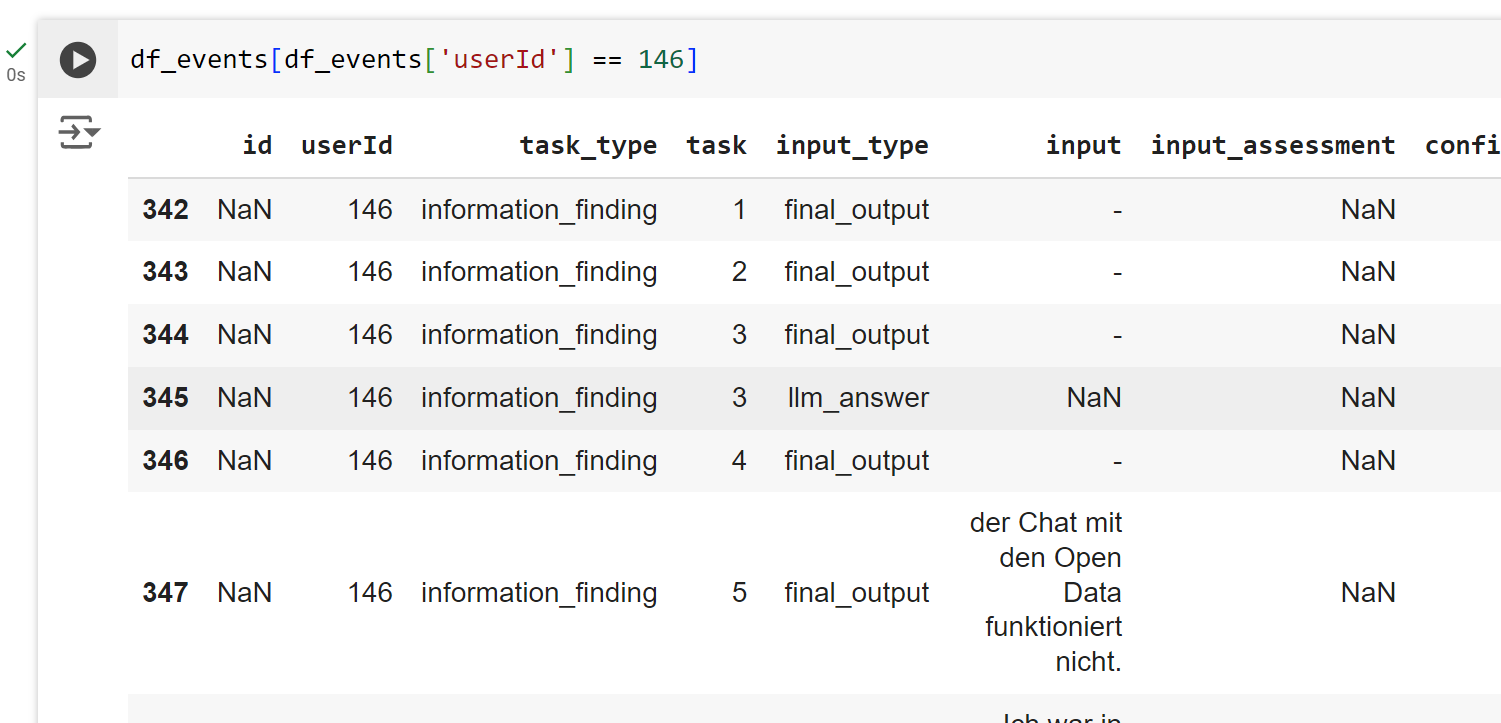



In [369]:
df_events_new['prompt_VADER'] = df_events_new['prompt_VADER'].replace([None, '', pd.NA], 0)
df_events_new['prompt_length'] = df_events_new['prompt_length'].replace([None, '', pd.NA], 0)
csv_file_path ='/content/drive/MyDrive/dataset/df_events_new.csv'
df_events_new.to_csv(csv_file_path, index=False)
df_events_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 0 to 800
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userId         405 non-null    int64  
 1   task           405 non-null    int64  
 2   final_output   405 non-null    object 
 3   confidence     405 non-null    float64
 4   understanding  405 non-null    float64
 5   valence        405 non-null    object 
 6   task_time      405 non-null    float64
 7   prompt_VADER   405 non-null    float64
 8   prompt_length  405 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 47.8+ KB


## Check message dataset
The message dataset mainly provides information about the **number of times a user interacts with the LLM** in order to get the best answer to a given question.


In [370]:
# Messages in this table are only for information finding task using the open assistant.
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userId          2560 non-null   int64 
 1   task            2560 non-null   int64 
 2   message_type    2560 non-null   object
 3   timestamp       2560 non-null   object
 4   input           2560 non-null   object
 5   timestamp_unix  2560 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 120.1+ KB


In [371]:
# Check all unique userId
df_messages['userId'].unique() #We have 93 participants here

array([127, 129, 131, 140, 144, 128, 125, 133, 135, 143, 124, 126, 138,
       142, 134, 141, 136, 145, 149, 150, 151, 152, 153, 154, 155, 156,
       158, 159, 160, 161, 162, 163, 164, 166, 168, 167, 169, 170, 171,
       172, 176, 179, 173, 174, 175, 177, 178, 181, 180, 183, 182, 184,
       185, 186, 187, 189, 190, 191, 192, 193, 194, 197, 198, 199, 201,
       203, 205, 206, 208, 207, 209, 211, 215, 217, 216, 219, 221, 222,
       223, 224, 225, 226, 228, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238])

In [372]:
# Check the differences between participants in the two datasets
set(df_messages['userId'].unique())-set(df_events_new['userId'].unique())

{127, 158, 162, 164, 166, 172, 181, 184, 194, 197, 205, 207, 231, 236}

There is no information about these user IDs {127, 158, 162, 164, 166, 172, 181, 194, 197, 205, 207, 231, 236} in the emotional events dataset, so we only focus on the cross dataset consisting of 80 participants.

In [373]:
df_messages_new = df_messages[df_messages['userId'].isin(df_events_new['userId'].unique())]
# drop the columns timestamp, timestamp_unix
df_messages_new = df_messages_new.drop(columns=['timestamp','timestamp_unix'])
df_messages_new

,userId,task,message_type,input
4,129,4,human,"{""input"": ""Wie hoch ist die Kitaquote in der S..."
5,129,4,agent_finish,"{""output"": ""Die Anzahl der Kitapl\u00e4tze bet..."
6,129,4,human,"{""input"": ""Gebe die Anzahl der Kitapl\u00e4tze..."
7,129,4,agent_finish,"{""output"": ""Die Anzahl der Kitapl\u00e4tze f\u..."
8,129,4,human,"{""input"": ""Wie viele Kinder unter 6 Jahren war..."
...,...,...,...,...
2555,238,5,agent_finish,"{""output"": ""In Oberwiehre gab es 2010 die meis..."
2556,238,5,human,"{""input"": ""wie viele Baugenehmigungen wurden i..."
2557,238,5,agent_finish,"{""output"": ""In Oberwiehre wurden insgesamt X B..."
2558,238,5,human,"{""input"": ""wie viele Baugenehmigungen sind in..."


Here, we want to create two different independent variables, "prompt length"and "prompt time"(named "length_of_prompt" and "prompt_times" separately) , to test whether there is an impact between these two features and the target variable "valence".

In [374]:
# Create two new independent variables named "length_of_prompt" and "prompt_times"
def count_human_messages(messages):
    return messages.str.contains('human').sum()

df_messages_new['prompt_times'] = df_messages_new.groupby(['userId', 'task'])['message_type'].transform(count_human_messages)
# Remove the columns "message_type" "input"

# For every userId and task, remain the first row of them, delete other rows which contains same userId	and task
df_messages_new = df_messages_new.drop_duplicates(subset=['userId', 'task'])
df_messages_new = df_messages_new.drop(columns=['message_type', 'input'])

df_messages_new

,userId,task,prompt_times
4,129,4,4
12,131,3,2
16,140,2,4
24,144,5,3
30,128,5,4
...,...,...,...
2525,238,2,7
2538,238,1,3
2544,238,4,2
2548,238,3,3


## Merge datasets


In [375]:
merged_data_ = pd.merge(df_messages_new, df_events_new, on=['userId', 'task'], how='left')
merged_data = pd.merge(merged_data_, df_users, on='userId', how='left')
# rearrange the column 'valence' at last
cols = [col for col in merged_data.columns if col != 'valence'] + ['valence']
# Change the type of valence
merged_data['valence'] = merged_data['valence'].astype(float)
merged_data = merged_data.reindex(columns=cols)
# Delete when education equals to D32
merged_data = merged_data[merged_data['education'] != 'D32']

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 385 entries, 0 to 389
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   userId                     385 non-null    int64  
 1   task                       385 non-null    int64  
 2   prompt_times               385 non-null    int64  
 3   final_output               385 non-null    object 
 4   confidence                 385 non-null    float64
 5   understanding              385 non-null    float64
 6   task_time                  385 non-null    float64
 7   prompt_VADER               385 non-null    float64
 8   prompt_length              385 non-null    int64  
 9   age                        385 non-null    int64  
 10  gender                     385 non-null    object 
 11  education                  385 non-null    object 
 12  assistant_usage            385 non-null    object 
 13  experience_analysis_tools  385 non-null    int64  
 14 

Now we create a data set consisting of 390 rows by 20 columns, but we still need some data processing steps.

# Feature Engineering

In [376]:
merged_data.columns

Index(['userId', 'task', 'prompt_times', 'final_output', 'confidence',
       'understanding', 'task_time', 'prompt_VADER', 'prompt_length', 'age',
       'gender', 'education', 'assistant_usage', 'experience_analysis_tools',
       'Trust 1', 'Trust 2', 'Trust 3', 'Satisfaction', 'Anthropomorphism',
       'valence'],
      dtype='object')

In [377]:
data = pd.concat([merged_data['task'],
               merged_data['prompt_times'], merged_data['understanding'],
               merged_data['task_time'], merged_data['prompt_VADER'],
               merged_data['prompt_length'], merged_data['education'],
               merged_data['assistant_usage'], merged_data['experience_analysis_tools'],
               merged_data['Satisfaction'], merged_data['valence']], axis=1)
# x['education'] = x['education'].map({'middle_school': 1, 'abitur': 2, 'bachelor': 3, 'master': 4, 'phd': 5})
# x['assistant_usage'] = x['assistant_usage'].map({'daily': 365, 'weekly': 52, 'monthly': 12, 'yearly': 1})
x= data.iloc[:,:-1]
x

,task,prompt_times,understanding,task_time,prompt_VADER,prompt_length,education,assistant_usage,experience_analysis_tools,Satisfaction
0,4,4,7.0,270.97,0.0772,24,bachelor,weekly,5,6
1,3,2,7.0,151.08,0.0000,9,master,daily,5,4
2,2,4,3.0,180.67,0.0000,3,phd,weekly,5,5
3,5,3,5.0,122.14,0.0000,9,bachelor,weekly,1,6
4,5,4,6.0,273.12,0.0000,9,abitur,monthly,3,5
...,...,...,...,...,...,...,...,...,...,...
385,2,7,1.0,211.52,0.3182,8,master,monthly,3,1
386,1,3,1.0,345.70,0.3182,20,master,monthly,3,1
387,4,2,2.0,175.46,0.0772,21,master,monthly,3,1
388,3,3,1.0,217.16,0.0000,9,master,monthly,3,1


In [378]:
def calculate_difficulty(task):
  if task == 1:
    return 4
  elif task == 2:
    return 3
  elif task == 3:
    return 3
  elif task == 4:
    return 2
  elif task == 5:
    return 3
  else:
    return None  # Handle cases where 'task' is not in [1, 2, 3, 4, 5]

x['task_difficulty'] = x['task'].apply(calculate_difficulty)
x.drop(columns=['task'], inplace=True)
x.head(20)

,prompt_times,understanding,task_time,prompt_VADER,prompt_length,education,assistant_usage,experience_analysis_tools,Satisfaction,task_difficulty
0,4,7.0,270.97,0.0772,24,bachelor,weekly,5,6,2
1,2,7.0,151.08,0.0000,9,master,daily,5,4,3
2,4,3.0,180.67,0.0000,3,phd,weekly,5,5,3
3,3,5.0,122.14,0.0000,9,bachelor,weekly,1,6,3
4,4,6.0,273.12,0.0000,9,abitur,monthly,3,5,3
5,2,4.0,238.62,0.7162,58,bachelor,daily,7,4,3
6,3,5.0,326.79,0.0000,10,bachelor,monthly,3,5,3
7,3,2.0,219.40,0.0000,11,bachelor,monthly,4,2,2
8,3,7.0,284.44,0.0000,14,bachelor,weekly,5,6,3
9,1,7.0,127.07,0.0000,11,bachelor,weekly,5,6,4


In [379]:
y_valence = data['valence']
# Rearrange the value of target, when valence euqals to 1.0, 2.0, reset to -1; 3.0, 4.0 reset to 0; 5.0, 6.0 reset to 1
y_valence = y_valence.apply(lambda x: -1 if x in [1.0, 2.0] else (0 if x in [3.0, 4.0] else (1 if x in [5.0, 6.0] else None)))

y_valence

,valence
0,-1
1,0
2,0
3,0
4,0
...,...
385,-1
386,-1
387,-1
388,-1


# Modelling

In [380]:
# Split the data into training and test sets
X_train, X_test, y_train_valence, y_test_valence = train_test_split(x, y_valence, test_size=0.3, random_state=42)

In [381]:
categorical_features = ['education','assistant_usage']
numeric_features = ['prompt_times','understanding','task_time', 'prompt_VADER', 'prompt_length', 'experience_analysis_tools','Satisfaction', 'task_difficulty']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [382]:
# Ignore FutureWarnings related to keepdims
warnings.filterwarnings("ignore", category=FutureWarning, message=".*keepdims.*")

# Dictionary of models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(kernel='rbf')
}

# Assume `preprocessor` is defined correctly and expects a DataFrame if necessary
X_train_transformed = preprocessor.fit_transform(X_train)

# Perform cross-validation and store the scores
cv_scores = {
    name: cross_val_score(model, X_train_transformed, y_train_valence, cv=5, scoring='accuracy')
    for name, model in models.items()
}


In [383]:
# Fit models and get predictions
Decision_model = Pipeline(steps=[('preprocessor', preprocessor),
                                ('class', DecisionTreeClassifier())])
Decision_model.fit(X_train, y_train_valence)
y_pred_deci_valence = Decision_model.predict(X_test)

RandomForest_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('class', RandomForestClassifier())])
RandomForest_model.fit(X_train, y_train_valence)
y_pred_RF_valence = RandomForest_model.predict(X_test)

SVC_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('class', SVC())])
SVC_model.fit(X_train, y_train_valence)
y_pred_SVC_valence = SVC_model.predict(X_test)


In [384]:
# Evaluate Decision Tree for Valence
accuracy_deci_valence = accuracy_score(y_test_valence, y_pred_deci_valence)
precision_deci_valence = precision_score(y_test_valence, y_pred_deci_valence, average='weighted')
recall_deci_valence = recall_score(y_test_valence, y_pred_deci_valence, average='weighted')
f1_deci_valence = f1_score(y_test_valence, y_pred_deci_valence, average='weighted')

# Evaluate Random Forest for Valence
accuracy_RF_valence = accuracy_score(y_test_valence, y_pred_RF_valence)
precision_RF_valence = precision_score(y_test_valence, y_pred_RF_valence, average='weighted')
recall_RF_valence = recall_score(y_test_valence, y_pred_RF_valence, average='weighted')
f1_RF_valence = f1_score(y_test_valence, y_pred_RF_valence, average='weighted')

# Evaluate SVC for Valence
accuracy_SVC_valence = accuracy_score(y_test_valence, y_pred_SVC_valence)
precision_SVC_valence = precision_score(y_test_valence, y_pred_SVC_valence, average='weighted')
recall_SVC_valence = recall_score(y_test_valence, y_pred_SVC_valence, average='weighted')
f1_SVC_valence = f1_score(y_test_valence, y_pred_SVC_valence, average='weighted')

# Print Valence results
print("Valence Metrics:")
print("Decision Tree - Accuracy:", accuracy_deci_valence, ", Precision:", precision_deci_valence, ", Recall:", recall_deci_valence, ", F1-score:", f1_deci_valence)
print("Random Forest - Accuracy:", accuracy_RF_valence, ", Precision:", precision_RF_valence, ", Recall:", recall_RF_valence, ", F1-score:", f1_RF_valence)
print("SVC - Accuracy:", accuracy_SVC_valence, ", Precision:", precision_SVC_valence, ", Recall:", recall_SVC_valence, ", F1-score:", f1_SVC_valence)

Valence Metrics:
Decision Tree - Accuracy: 0.6293103448275862 , Precision: 0.6401340996168583 , Recall: 0.6293103448275862 , F1-score: 0.6332931558536841
Random Forest - Accuracy: 0.7327586206896551 , Precision: 0.7517939533754249 , Recall: 0.7327586206896551 , F1-score: 0.7231801670687648
SVC - Accuracy: 0.6810344827586207 , Precision: 0.6365832222445056 , Recall: 0.6810344827586207 , F1-score: 0.6414648888676107


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Importance Analysis



In [385]:
# Extract feature importances from the RandomForest model
importances = RandomForest_model.named_steps['class'].feature_importances_

# Get feature names
# Combine numeric features with the categorical features that were one-hot encoded
feature_names = numeric_features + list(RandomForest_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

# Combine feature names with their corresponding importances into a DataFrame
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print(feature_importance)


                      Feature  Importance
1               understanding    0.256978
2                   task_time    0.143037
4               prompt_length    0.105988
6                Satisfaction    0.084142
0                prompt_times    0.080263
5   experience_analysis_tools    0.078850
7             task_difficulty    0.042264
3                prompt_VADER    0.037042
8            education_abitur    0.024158
16     assistant_usage_yearly    0.023815
15     assistant_usage_weekly    0.021863
13      assistant_usage_daily    0.021009
10           education_master    0.020252
14    assistant_usage_monthly    0.019889
9          education_bachelor    0.019442
12              education_phd    0.015799
11    education_middle_school    0.005209


<ipython-input-386-172d2982b16a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='Set2')


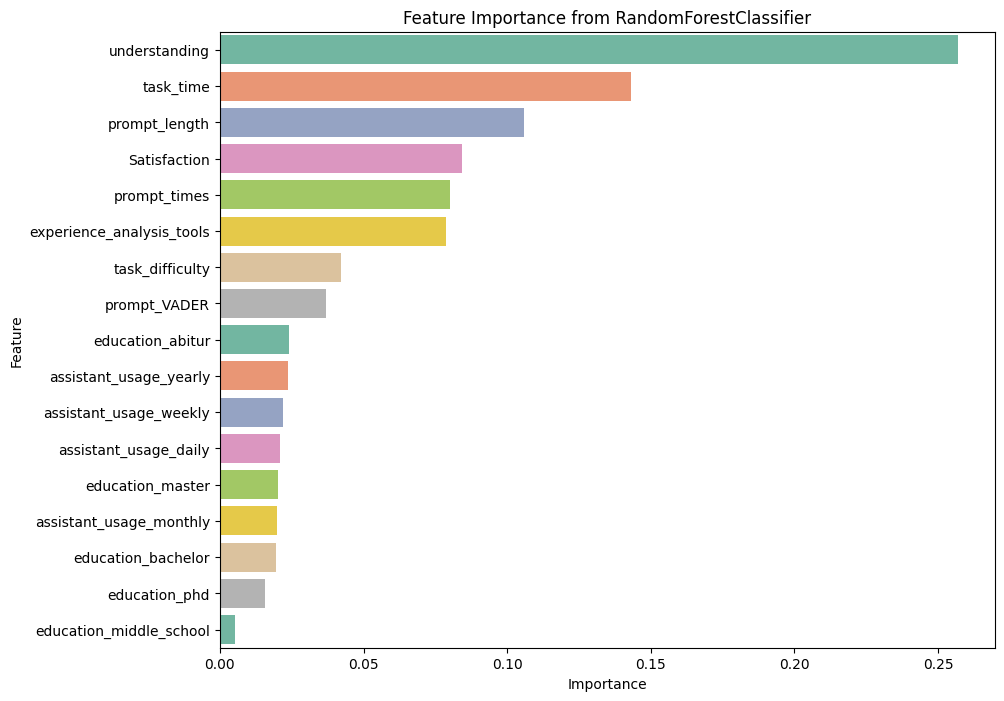

In [386]:
# Visualization with different colors using the 'Set2' palette
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='Set2')

plt.title('Feature Importance from RandomForestClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.show()
